Homework 4:
---
For this homework we will be building various neural networks to classify handwritten digits.

### Question 1: Feed-Forward Neural Network to classify MNIST digits.

Train a neural network to classify MNIST digits. Remember we have to pick 3 different components to build a neural network: (1) Network Architecture (2) Loss Function and (3) Optimizer. For this assignment use the following:

Network Architecture:
* [28x28] input 
* -> Use a view to reshape to [784]
* -> Linear Layer [784, Num Hidden Units]
* -> Relu
* -> Output Linear Layer [NumHiddenUnits, 10]
* -> Log Softmax (`torch.nn.functional.log_softmax(output)`)

Loss: Please use the negative log likelihood loss function (nll_loss).
Optimizer: Please use SGD optimizer (https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD), but you can also experiment with Adam optimizer in 1.6.

1.1: Create a Pytorch module to implement a version of this neural network. Display the shape of the network using ` torchsummary.summary`.

1.2 Create a training loop to train this model using SGD optimizer. Note, we should train using minibatches. The dataloader will create minibatches for you automatically and you can just loop through as follows:

```
for epoch in range(0, num_epochs):
  # Loop over the dataloader and get minibatches:
  for batch_idx, (data, target) in enumerate(train_dataloader):
    # TODO: Reset gradient on optimizer
    # TODO: Evaluate th emodel on data
    # TODO: Calculate loss using nll_loss
    # TODO: Evaluate gradient with respect to the loss function
    # TODO: Run a step of the optimizer.
    # TODO: Store the loss function for plotting every X batches.
```


1.3 Train your model on MNIST digits. Please record the training loss every 100 minibatch steps. Display this as a plot where the x axis is the minibatch index and the y axis is the training loss at that step.

1.4: Create a classifier for your model. The output of your model can be evaluated by usuing the forward function, or just calling the model ```trained_nn_model(sample)```. The output of your model will be a tensor of 10 values representing the log softmax value for each class. You can build a classifier by simply taking the index with the highest value. For example if the classifier outputs `[.1, .2, .6, .1]` you would classify it as class 2.

1.5: Create and display a confusion matrix for your classifier on your Train and Test data using https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html. Discuss what you observe from this confusion matrix. Which digits are mistaken for each other?

1.6: Experiment with different network shapes (number of hidden layers and number of hidden units per layer) or optimizers (for example, you can try Adam instead of SGD). Report the Train and Test accuracy of at least 4 experiments here and discuss what works well and what does not.

1.7: Find some examples of images your model misclassifies. Display these images and discuss why the model does not work well on them. 

### Question 2: Convolutional Neural Network to classify MNIST digits.

We will answer similar questions as above but using a convolutional neural network. Please start with this example network module: ```SimpleConvNetModel```

2.1: Create a Pytorch module to implement a version of this neural network as implemented above. Display the shape of the network using ` torchsummary.summary`.

2.2 Create a training loop to train this model using Adam optimizer. This should be similar to 1.2.

2.3 Train your model on MNIST digits. Please record the training loss every 100 minibatch steps. Display this as a plot where the x axis is the minibatch index and the y axis is the training loss at that step.

2.4: Create a classifier for your model and report train and test accuracy. How does this compare to the performance of your non-convolutional neural network in question 1?

2.5: Create and display a confusion matrix for your classifier on your Train and Test data. Discuss what you observe from this confusion matrix. Which digits are mistaken for each other? How does this differ from 1.5?

2.6: Experiment with different kernel sizes and stride parameters to your convolutions. Report the Train and Test accuracy of at least 2 experiments here and discuss what works well and what does not.

2.7: Experiment with the network structure. Can you add in an additional convolution? Report the Train and Test accuracy of at least 2 experiments here and discuss what works well and what does not.

Extra Credit 2.8: Use ```visualize_conv_model_weights``` to display convolutional network weights. Display for each convolutional layer. Please interpret these images and describe what they are showing.

In [2]:
# Imports
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import figure
from matplotlib import cm
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
# Load the MNIST dataset:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
mnist_train_dataset = torchvision.datasets.MNIST(
    root='../../Data', train=True, download=True, transform=transform) 
mnist_test_dataset = torchvision.datasets.MNIST(
    root='../../Data', train=False, download=True, transform=transform)

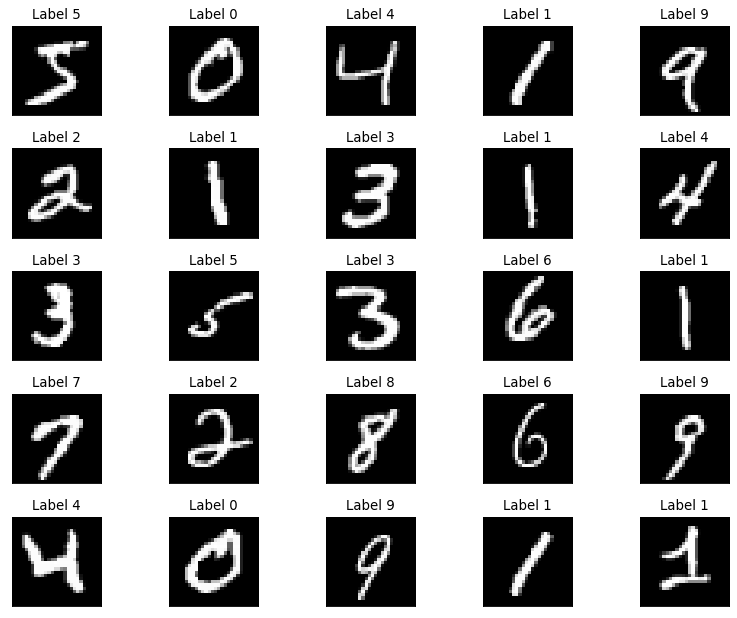

In [4]:
def image_grid(data, num_figs):
    """Function to display a grid of images
    Args:
      data: torchvision dataset
      num_figs: number of images to display
    """
    fig = figure(figsize=(10, 8), dpi=80)
    for i in range(num_figs):
        fig_i = int(math.sqrt(num_figs))
        plt.subplot(fig_i, fig_i, i+1)
        plt.tight_layout()
        image, label = data[i]
        plt.imshow(image.reshape(28, 28), cmap='gray')
        plt.title(f"Label {label}")
        plt.xticks([])
        plt.yticks([])
image_grid(mnist_train_dataset, 25)

In [5]:
# Let's set the random seed so we will get the same behavior each run.
random_seed = 42
torch.manual_seed(random_seed)

# Let's make sure to turn off GPU backend in case you happen to have GPU. The only
# reason we do this is not to have to worry about moving data and models on and
# off of the GPU for now. If you are training large models and have a GPU, then
# you will want to use it.
torch.backends.cudnn.enabled = False

In [6]:
# Put training and test data into data loaders allow batching of datasets.
batch_size_train = 64
batch_size_test = 1000
train_loader = torch.utils.data.DataLoader(mnist_train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test_dataset, batch_size=batch_size_test, shuffle=True)
num_dimensions, num_classes = 28**2, 10

Question 1.1: Create a Pytorch module to implement a version of this neural network. Display the shape of the network using ` torchsummary.summary`.

In [7]:
# Question 1.1
class SimpleNeuralNet(nn.Module):
    def __init__(self, hidden_units):
        super().__init__()
        self.linear = nn.Linear(num_dimensions, hidden_units)
        self.output_layer = nn.Linear(hidden_units, num_classes)

    def forward(self, x):
        x = x.view(-1, num_dimensions)
        z1 = self.linear(x)
        a1 = F.relu(z1)
        z2 = self.output_layer(a1)
        return F.log_softmax(z2, dim=1)

nn_model = SimpleNeuralNet(20)
summary(nn_model, (1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 20]                  15,700
├─Linear: 1-2                            [-1, 10]                  210
Total params: 15,910
Trainable params: 15,910
Non-trainable params: 0
Total mult-adds (M): 0.02
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.06
Estimated Total Size (MB): 0.06


Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 20]                  15,700
├─Linear: 1-2                            [-1, 10]                  210
Total params: 15,910
Trainable params: 15,910
Non-trainable params: 0
Total mult-adds (M): 0.02
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.06
Estimated Total Size (MB): 0.06

Question 1.2: Create a training loop to train this model using SGD optimizer. Note, we should train using minibatches. The dataloader will create minibatches for you automatically and you can just loop through as follows:

In [8]:
# Question 1.2
# Note: for SGD optimizer just put it in the parameter
# Example: train(model, epochs, training_data, minibatch_steps, optimizer, loss_function): 
def train(model, epochs, training_data, minibatch_steps, optimizer, loss_function): 
    errors = []
    for epochs in range(epochs):
        for batch_idx, (data, target) in enumerate(training_data):
            optimizer.zero_grad()
            output = model(data)
            loss = loss_function(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % minibatch_steps == 0:
                errors.append(loss.item())
    return errors

Question 1.3: Train your model on MNIST digits. Please record the training loss every 100 minibatch steps. Display this as a plot where the x axis is the minibatch index and the y axis is the training loss at that step.

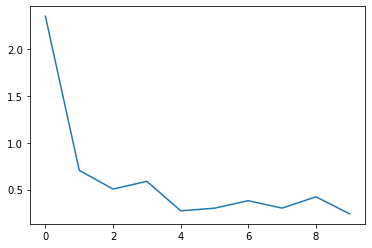

In [15]:
# Question 1.3
optimizer = torch.optim.SGD(nn_model.parameters(), lr=1e-1) # Optimizer is SGD as declared by Question 1.2
minibatch_steps = 100 # <--- Recording the loss every 100 mini batch steps as declared by Question 1.3
errors = train(nn_model, 1, train_loader, minibatch_steps, optimizer, F.nll_loss)
plt.plot(errors)
plt.show()

Question 1.4: Create a classifier for your model. The output of your model can be evaluated by usuing the forward function, or just calling the model trained_nn_model(sample). The output of your model will be a tensor of 10 values representing the log softmax value for each class. You can build a classifier by simply taking the index with the highest value. For example if the classifier outputs [.1, .2, .6, .1] you would classify it as class 2.

In [16]:
# Question 1.4
def classifier(model, data_loader):
    correct, total = 0, 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            output = model(data)
            predicted = torch.max(output.data, 1)[1] # Takes the index with the highest value
            total += target.size(0)                    
            correct += (predicted == target).sum().item() 
    return 100 * correct / total 

In [17]:
print("Training Accuracy:", classifier(nn_model, train_loader))
print("Testing Accuracy:", classifier(nn_model, test_loader))

Training Accuracy: 87.375
Testing Accuracy: 87.72


Question 1.5: Create and display a confusion matrix for your classifier on your Train and Test data using https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html. Discuss what you observe from this confusion matrix. Which digits are mistaken for each other?  
Answer 1.5 <---> Look under the confusion matrix graph for the discussion for question 1.5

In [19]:
# Question 1.5 - This function returns the display of the confusion matrix 
def confusionMatrix(model, data_loader):
    y_true, y_pred = [], []
    with torch.no_grad(): 
        for batch_idx, (data, target) in enumerate(data_loader):
            output = model(data)
            y_pred.extend(torch.max(output.data, 1)[1].numpy())
            y_true.extend(target.numpy())

    # Displaying in a confusion Matrix
    matrix = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    return ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

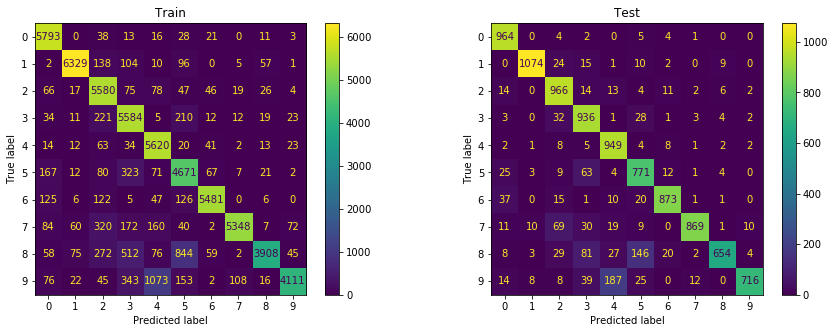

In [20]:
# Displaying Train and Test confusion matrixes side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set_title("Train")
confusionMatrix(nn_model, train_loader).plot(ax=ax[0])
ax[1].set_title("Test")
confusionMatrix(nn_model, test_loader).plot(ax=ax[1])
plt.show()

Answer 1.5:

Question 1.6: Experiment with different network shapes (number of hidden layers and number of hidden units per layer) or optimizers 
(for example, you can try Adam instead of SGD). Report the Train and Test accuracy of at least 4 experiments here and discuss what works well and what does not.  
Answer 1.6 <---> Look for discussion which is located right underneath experiment 4

In [228]:
# Experiment 1 - For this experiment we will more hidden_units than the original nn model and the same hidden_layers
# Since we have the hidden_units parameter in SimpleNeuralNet we can input the parameter for a different network shape
nn_1 = SimpleNeuralNet(30) 
train(nn_1, 1, train_loader, 100, torch.optim.SGD(nn_1.parameters(), lr=1e-1), F.nll_loss) 
print("Experiment 1 Results")
print("Training Accuracy:", classifier(nn_1, train_loader))
print("Testing Accuracy:", classifier(nn_1, test_loader))


Experiment 1 Results
Training Accuracy: 86.61166666666666
Testing Accuracy: 86.64


In [231]:
# Experiment 2 - For this experiment we will use less hidden_units than the original nn model and the same hidden_layers
# Since we have the hidden_units parameter in SimpleNeuralNet we can input the parameter for a different network shape
nn_2 = SimpleNeuralNet(15) 
train(nn_2, 1, train_loader, 100, torch.optim.SGD(nn_2.parameters(), lr=1e-1), F.nll_loss) 
print("Experiment 2 Results")
print("Training Accuracy:", classifier(nn_2, train_loader))
print("Testing Accuracy:", classifier(nn_2, test_loader))


Experiment 2 Results
Training Accuracy: 78.92833333333333
Testing Accuracy: 78.7


In [234]:
# Experiment 3 - for this experiment we will use more hidden layers - Unfortunately to add more hidden layers we need to redefine the model
class nn_experiment(nn.Module):
    def __init__(self, hidden_units1, hidden_units2):
        super().__init__()
        self.linear = nn.Linear(num_dimensions, hidden_units1)
        self.linear2 = nn.Linear(hidden_units1, hidden_units2)
        self.output_layer = nn.Linear(hidden_units2, num_classes)

    def forward(self, x):
        x = x.view(-1, num_dimensions)
        z1 = self.linear(x)
        a1 = F.relu(z1)
        z2 = self.linear2(a1)
        a2 = F.relu(z2)
        z3 = self.output_layer(a2)
        return F.log_softmax(a2, dim=1)

nn_3 = nn_experiment(30, 15)
train(nn_3, 1, train_loader, 100, torch.optim.SGD(nn_3.parameters(), lr=1e-1), F.nll_loss) 
print("Experiment 3 Results")
print("Training Accuracy:", classifier(nn_3, train_loader))
print("Testing Accuracy:", classifier(nn_3, test_loader))

Experiment 3 Results
Training Accuracy: 81.425
Testing Accuracy: 82.29


In [239]:
# Experiment 4 - for this experiment we will examine the performance using the Adam optimizer over the SGD optimizer
nn_4 = nn_experiment(30, 15)
train(nn_4, 1, train_loader, 100, torch.optim.Adam(nn_4.parameters(), lr=1e-1), F.nll_loss) 
print("Experiment 4 Results")
print("Training Accuracy:", classifier(nn_4, train_loader))
print("Testing Accuracy:", classifier(nn_4, test_loader))

Experiment 4 Results
Training Accuracy: 10.218333333333334
Testing Accuracy: 10.1


Answer 1.6:
explain results ...  what is nonsense? 10.21% LOL

Question 1.7: Find some examples of images your model misclassifies. Display these images and discuss why the model does not work well on them.  
Answer 1.7 <---> Look under misclassification images to find discusion

Misclassification Found! True Value: 7 Predicted Value: 0


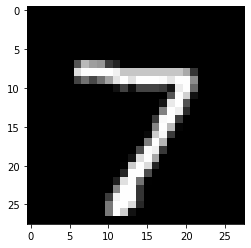

Misclassification Found! True Value: 2 Predicted Value: 1


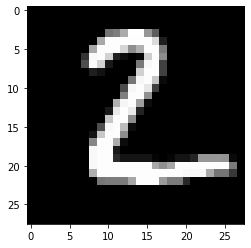

In [367]:
# Question 1.7
def misclassification(model, dataset, num_misclassification):
    # batch_size = 1 so we check 1 img at a time 
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False) 
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader): 
            output = model(data)
            predicted = torch.max(output.data, 1)[1]
            image, label = dataset[batch_idx]
            if target.item() != predicted.item():
                print(f"Misclassification Found! True Value: {target.item()} Predicted Value: {predicted.item()}")
                plt.imshow(image.reshape(28, 28), cmap='gray')
                plt.show()
                num_misclassification -= 1
                if num_misclassification == 0:
                    break;  

misclassification(nn_model, mnist_test_dataset, 2)


Answer 1.7

Question 2.1: Create a Pytorch module to implement a version of this neural network as implemented above. Display the shape of the network using torchsummary.summary

In [133]:
class SimpleConvNetModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.dense_layer = nn.Linear(320, 50)
        self.output_layer = nn.Linear(50, num_classes)

    def forward(self, x):
        
        # First convolutional layer.
        z1 = self.conv1(x)
        # Apply max pooling to convolution.
        z1_pooled = F.max_pool2d(z1, 2)
        # Apply ReLu to pooled convolution.
        a1 = F.relu(z1_pooled)
        
        # Second convolutional layer
        z2 = self.conv2(a1)
        # Apply max pooling to convolution.
        z2_pooled = F.max_pool2d(z2, 2)        
        # Apply ReLu to pooled convolution
        a2 = F.relu(z2_pooled)
        # View as 1-dimensional vector:
        a2 = a2.view(-1, 320) 
        
        # Dense linear layer
        z3_hidden = self.dense_layer(a2)
        # Apply ReLu to linear layer.
        a3 = F.relu(z3_hidden)
        # Run dropout in training to help prevent overfitting
        a3_dropout = F.dropout(a3, training=self.training)
        
        # Run through linear output layer.
        output = self.output_layer(a3_dropout)
        # Apply softmax to output layer:
        return F.log_softmax(output, dim=1)

cnn_model = SimpleConvNetModel()
summary(cnn_model, (1, 28, 28))     

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 10, 24, 24]          260
├─Conv2d: 1-2                            [-1, 20, 8, 8]            5,020
├─Linear: 1-3                            [-1, 50]                  16,050
├─Linear: 1-4                            [-1, 10]                  510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
Total mult-adds (M): 0.48
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.08
Estimated Total Size (MB): 0.14


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 10, 24, 24]          260
├─Conv2d: 1-2                            [-1, 20, 8, 8]            5,020
├─Linear: 1-3                            [-1, 50]                  16,050
├─Linear: 1-4                            [-1, 10]                  510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
Total mult-adds (M): 0.48
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.08
Estimated Total Size (MB): 0.14

Question 2.2: Create a training loop to train this model using Adam optimizer. This should be similar to 1.2.

In [44]:
# Question 2.2
# errors = []
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
# for epochs in range(epochs):
#     for batch_idx, (data, target) in enumerate(training_data):
#         optimizer.zero_grad()
#         output = model(data)
#         loss = loss_function(output, target)
#         loss.backward()
#         optimizer.step()
#         if batch_idx % minibatch_steps == 0: 
# return errors
# The above training loop is basically the train() function defined with the parameter optimizer=torch.optim.Adam(model.parameters(), lr=1e-2)

Question 2.3: Train your model on MNIST digits. Please record the training loss every 100 minibatch steps. Display this as a plot where the x axis is the minibatch index and the y axis is the training loss at that step.

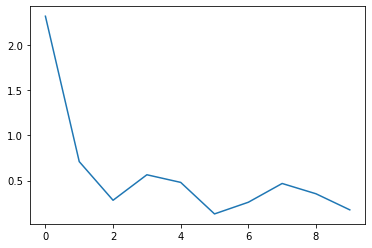

In [134]:
# Question 2.3
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-2) 
minibatch_steps = 100 # required by question 2.3
errors = train(cnn_model, 1, train_loader, minibatch_steps, optimizer, F.nll_loss)
plt.plot(errors)
plt.show()

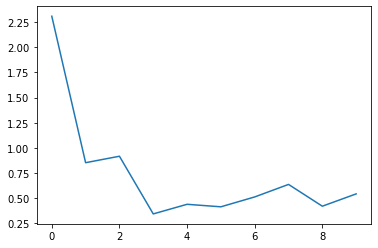

In [214]:
# Question 2.3
# NOTE: I used lr=1e-2 because lr=1e=-1 had terrible results 
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-2) # Adam optimizer required by question 2.2 
minibatch_steps = 100 # required by question 2.3
errors = train(cnn_model, 1, train_loader, minibatch_steps, optimizer, F.nll_loss)
plt.plot(errors)
plt.show()

Question 2.4: Create a classifier for your model and report train and test accuracy. How does this compare to the performance of your non-convolutional neural network in question 1?  
Answer 2.4 <---> Look for discussion below performance printout

In [122]:
# Question 2.4
# correct, total = 0, 0
# with torch.no_grad():
#     for batch_idx, (data, target) in enumerate(data_loader):
#         output = model(data)
#         predicted = torch.max(output.data, 1)[1] # Takes the index with the highest value
#         total += target.size(0)                    
#         correct += (predicted == target).sum().item() 
# return 100 * correct / total 
# The commented out code is executed in the classifier() function
print("Training Accuracy:", classifier(cnn_model, train_loader))
print("Testing Accuracy:", classifier(cnn_model, test_loader))

Training Accuracy: 92.005
Testing Accuracy: 92.43


Question 2.5: Create and display a confusion matrix for your classifier on your Train and Test data. Discuss what you observe from this confusion matrix. Which digits are mistaken for each other? How does this differ from 1.5?  
Answer 2.5 <---> Look under confusion matrix graphs to find discusion

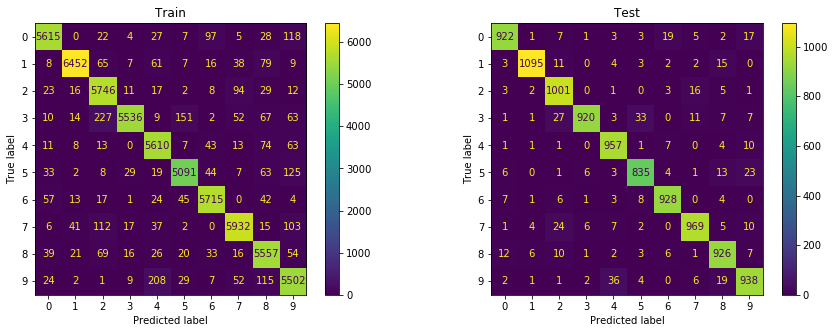

In [52]:
# Question 2.5
# Displaying Train and Test confusion matrixes side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set_title("Train")
confusionMatrix(cnn_model, train_loader).plot(ax=ax[0])
ax[1].set_title("Test")
confusionMatrix(cnn_model, test_loader).plot(ax=ax[1])
plt.show()

Question 2.6: Experiment with different kernel sizes and stride parameters to your convolutions. Report the Train and Test accuracy of at least 2 experiments here and discuss what works well and what does not.  
Answer 2.6 <---> Look under discussion under experiment 4 to find discusion

In [98]:
# Experiment 1 - We will experiment making the kernel size bigger, in this case we will try a kernel size of 6 instead of 5
class CNN_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=6)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=6)
        self.dense_layer = nn.Linear(180, 50)
        self.output_layer = nn.Linear(50, num_classes)

    def forward(self, x):
        
        # First convolutional layer.
        z1 = self.conv1(x)
        # Apply max pooling to convolution.
        z1_pooled = F.max_pool2d(z1, 2)
        # Apply ReLu to pooled convolution.
        a1 = F.relu(z1_pooled)
        
        # Second convolutional layer
        z2 = self.conv2(a1)
        # Apply max pooling to convolution.
        z2_pooled = F.max_pool2d(z2, 2)        
        # Apply ReLu to pooled convolution
        a2 = F.relu(z2_pooled)
        
        # View as 1-dimensional vector:
        a2 = a2.view(-1, 180) 
        
        # Dense linear layer
        z3_hidden = self.dense_layer(a2)
        # Apply ReLu to linear layer.
        a3 = F.relu(z3_hidden)
        # Run dropout in training to help prevent overfitting
        a3_dropout = F.dropout(a3, training=self.training)
        
        # Run through linear output layer.
        output = self.output_layer(a3_dropout)
        # Apply softmax to output layer:
        return F.log_softmax(output, dim=1)

cnn1 = CNN_1()
train(cnn1, 1, train_loader, 100, torch.optim.Adam(cnn1.parameters(), lr=1e-2), F.nll_loss) 
print("Training Accuracy:", classifier(cnn1, train_loader))
print("Testing Accuracy:", classifier(cnn1, test_loader))

Training Accuracy: 92.30333333333333
Testing Accuracy: 92.55


In [139]:
# Experiment 2 - We will experiment by making the stride=2 but keeping the kernel_size the same as the SimpleConvNetModel
class CNN_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=2)
        self.dense_layer = nn.Linear(20, 50)
        self.output_layer = nn.Linear(50, num_classes)

    def forward(self, x):
        
        # First convolutional layer.
        z1 = self.conv1(x)
        # Apply max pooling to convolution.
        z1_pooled = F.max_pool2d(z1, 2)

        # Apply ReLu to pooled convolution.
        a1 = F.relu(z1_pooled)

        # Second convolutional layer
        z2 = self.conv2(a1)
        # Apply max pooling to convolution.
        #z2_pooled = F.max_pool2d(z2, 2)      
        # Apply ReLu to pooled convolution
        a2 = F.relu(z2)
        # View as 1-dimensional vector:
        a2 = a2.view(-1, 20) 
        
        # Dense linear layer
        z3_hidden = self.dense_layer(a2)
        # Apply ReLu to linear layer.
        a3 = F.relu(z3_hidden)
        # Run dropout in training to help prevent overfitting
        a3_dropout = F.dropout(a3, training=self.training)
        
        # Run through linear output layer.
        output = self.output_layer(a3_dropout)
        # Apply softmax to output layer:
        return F.log_softmax(output, dim=1)

cnn2 = CNN_2()
train(cnn2 1, train_loader, 100, torch.optim.Adam(cnn3.parameters(), lr=1e-2), F.nll_loss) 
print("Training Accuracy:", classifier(cnn2, train_loader))
print("Testing Accuracy:", classifier(cnn2, test_loader))

Training Accuracy: 93.99
Testing Accuracy: 94.16


Answer 2.6:

Question 2.7: Experiment with the network structure. Can you add in an additional convolution? Report the Train and Test accuracy of at least 2 experiments here and discuss what works well and what does not.

In [64]:
class CNN_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=4)
        self.conv2 = nn.Conv2d(10, 10, kernel_size=4)
        self.conv3 = nn.Conv2d(10, 20, kernel_size=4)
        self.dense_layer = nn.Linear(10, 50)
        self.output_layer = nn.Linear(50, num_classes)

    def forward(self, x):
    
        # First convolutional layer.
        z1 = self.conv1(x)
        # Apply max pooling to convolution.
        z1_pooled = F.max_pool2d(z1, 2)
        # Apply ReLu to pooled convolution.
        a1 = F.relu(z1_pooled)
        
        # Second convolutional layer
        z2 = self.conv2(a1)
        # Apply max pooling to convolution.
        z2_pooled = F.max_pool2d(z2, 2)        
        # Apply ReLu to pooled convolution
        a2 = F.relu(z2_pooled)

        # third convolutional layer
        z3 = self.conv2(a2)
        # Apply max pooling to convolution.
        z3_pooled = F.max_pool2d(z3, 1) 
        # Apply ReLu to pooled convolution
        a3 = F.relu(z3)

        # View as 1-dimensional vector:
        a3 = a3.view(-1, 10) 

        # Dense linear layer
        z3_hidden = self.dense_layer(a3)
        # Apply ReLu to linear layer.
        a3 = F.relu(z3_hidden)
        # Run dropout in training to help prevent overfitting
        a3_dropout = F.dropout(a3, training=self.training)
        
        # Run through linear output layer.
        output = self.output_layer(a3_dropout)
        # Apply softmax to output layer:
        return F.log_softmax(output, dim=1)

cnn3 = CNN_3()
train(cnn3, 1, train_loader, 100, torch.optim.Adam(cnn3.parameters(), lr=1e-2), F.nll_loss) 
print("Training Accuracy:", classifier(cnn3, train_loader))
print("Testing Accuracy:", classifier(cnn3, test_loader))  

Training Accuracy: 92.02
Testing Accuracy: 92.23


In [129]:
class CNN_4(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=1)
        self.conv2 = nn.Conv2d(10, 10, kernel_size=1)
        self.conv3 = nn.Conv2d(10, 20, kernel_size=4)
        self.conv4 = nn.Conv2d(20, 40, kernel_size=4)
        self.dense_layer = nn.Linear(490, 50)
        self.output_layer = nn.Linear(50, num_classes)

    def forward(self, x):
    
        # First convolutional layer.
        z1 = self.conv1(x)
        # Apply max pooling to convolution.
        z1_pooled = F.max_pool2d(z1, 2)
        # Apply ReLu to pooled convolution.
        a1 = F.relu(z1_pooled)

        # Second convolutional layer
        z2 = self.conv2(a1)
        # Apply max pooling to convolution.
        z2_pooled = F.max_pool2d(z2, 2)        
        # Apply ReLu to pooled convolution
        a2 = F.relu(z2_pooled)

        # third convolutional layer
        z3 = self.conv2(a2)
        # Apply max pooling to convolution.
        z3_pooled = F.max_pool2d(z3, 2)
        # Apply ReLu to pooled convolution
        a3 = F.relu(z3)

        # third convolutional layer
        z4= self.conv2(a3)
        # Apply max pooling to convolution.
        z4_pooled = F.max_pool2d(z4, 2) 
        # Apply ReLu to pooled convolution
        a4 = F.relu(z4)

        # View as 1-dimensional vector:
        a4 = a4.view(-1, 490) 

        # Dense linear layer
        z5_hidden = self.dense_layer(a4)
        # Apply ReLu to linear layer.
        a5 = F.relu(z5_hidden)
        # Run dropout in training to help prevent overfitting
        a5_dropout = F.dropout(a5, training=self.training)
        
        # Run through linear output layer.
        output = self.output_layer(a5_dropout)
        # Apply softmax to output layer:
        return F.log_softmax(output, dim=1)

cnn4 = CNN_4()
train(cnn4, 1, train_loader, 100, torch.optim.Adam(cnn4.parameters(), lr=1e-2), F.nll_loss) 
print("Training Accuracy:", classifier(cnn4, train_loader))
print("Testing Accuracy:", classifier(cnn4, test_loader))  

Training Accuracy: 72.70833333333333
Testing Accuracy: 72.16


In [131]:
def visualize_conv_model_weights(model, layer=0):
    """Visualize the weights in the convolutions.
    Args:
      model: Trained convolutional neural net
      layer: which layer to try to visualize. Layer 0 corresponds to conv1, Layer 1 corresponds to conv2
    """
    if layer > 1:
        raise Exception("Convolutional layers are 0 and 1")
    conv_weights = list(model.children())[layer].weight 
    plt.figure(figsize=(20, 17))
    for i, filter in enumerate(conv_weights):
        plt.subplot(8, 8, i+1)
        plt.imshow(filter[0, :, :].detach(), cmap='gray')
        plt.axis('off')
    plt.show()

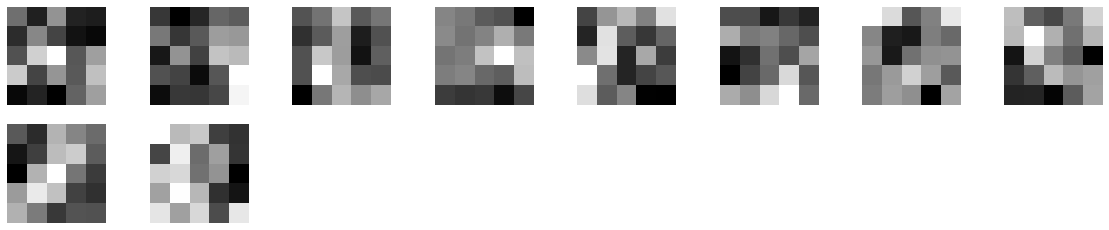

In [135]:
visualize_conv_model_weights(cnn_model, layer=0)

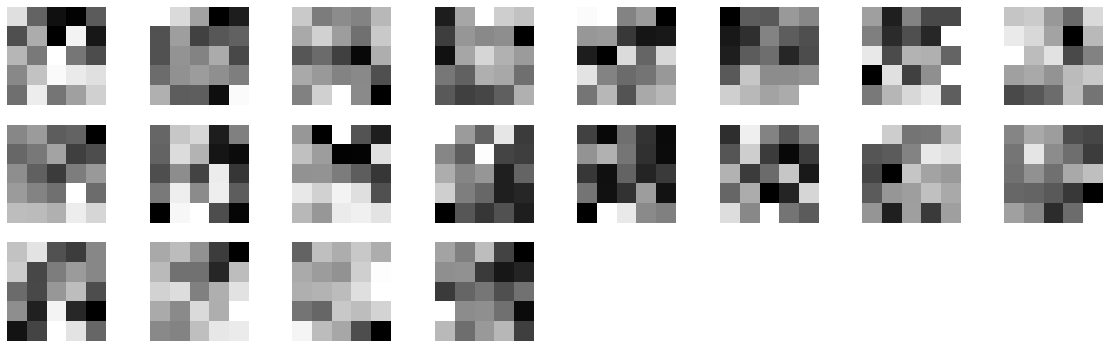

In [136]:
visualize_conv_model_weights(cnn_model, layer=1)